In [1]:

"""
Seismic Magnitude Prediction using CNN on 3-component seismic data.

This module implements a 1D CNN for predicting earthquake magnitudes from
3-component seismic waveforms with data augmentation and weighted loss
to handle class imbalance.

Author: Samuel Hayat
Date: 17/08/2025
Version: 1.0
"""

'\nSeismic Magnitude Prediction using CNN on 3-component seismic data.\n\nThis module implements a 1D CNN for predicting earthquake magnitudes from\n3-component seismic waveforms with data augmentation and weighted loss\nto handle class imbalance.\n\nAuthor: Samuel Hayat\nDate: 17/08/2025\nVersion: 1.0\n'

In [2]:
# Standard imports

import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

In [3]:

class SeismicAugmentation:
    """
    Data augmentation techniques for seismic signals.

    Applies realistic transformations to seismic waveforms including:
    - Gaussian noise injection
    - Time shifting (P-wave arrival variation)
    - Amplitude scaling (distance/site effects)
    - Time stretching (velocity variations)
    """
    def __init__(self, noise_factor=0.05, time_shift_max=20,
                 amplitude_scale_range=(0.8, 1.2), time_stretch_range=(0.95, 1.05)):
        self.noise_factor = noise_factor
        self.time_shift_max = time_shift_max
        self.amplitude_scale_range = amplitude_scale_range
        self.time_stretch_range = time_stretch_range

    def add_noise(self, signal):
        noise = np.random.normal(0, self.noise_factor * np.std(signal), signal.shape)
        return signal + noise

    def time_shift(self, signal):
        shift = random.randint(-self.time_shift_max, self.time_shift_max)
        if shift > 0:
            return np.pad(signal[:, :-shift], ((0, 0), (shift, 0)), mode='edge')
        elif shift < 0:
            return np.pad(signal[:, -shift:], ((0, 0), (0, -shift)), mode='edge')
        return signal

    def amplitude_scaling(self, signal):
        scale = random.uniform(*self.amplitude_scale_range)
        return signal * scale

    def augment(self, signal):
        aug_signal = signal.copy()
        if random.random() > 0.3: aug_signal = self.add_noise(aug_signal)
        if random.random() > 0.5: aug_signal = self.time_shift(aug_signal)
        if random.random() > 0.4: aug_signal = self.amplitude_scaling(aug_signal)
        return aug_signal

In [4]:
class SeismicDatasetFromDF(Dataset):
    def __init__(self, df, target_length=250, scaler=None, augment_rare=False):
        self.df = df.reset_index(drop=True)
        self.target_length = target_length
        self.scaler = scaler

        if len(self.df) > 0:
            sample_snippet = self.df.iloc[0]['snippet']
            # print(f"Shape of snippets: {sample_snippet.shape}")

        # Calculate stats for normalization if no scaler provided
        if self.scaler is None:
            all_snippets = []
            for idx in range(0, min(1000, len(self.df))):  # Sample for stats calculation
                snippet = self._process_snippet(self.df.iloc[idx]['snippet'])
                all_snippets.append(snippet)

            # Ensure data is 2D for stats computation
            sample_data = np.vstack([s.flatten() for s in all_snippets])  # Flatten each sample

            # Simple normalization: global Z-score
            self.mean = np.mean(sample_data)
            self.std = np.std(sample_data)

        self.augment_rare = augment_rare and scaler is None  # Only for training set
        if self.augment_rare:
            self.augmenter = SeismicAugmentation()
            self.rare_indices = list(df[df['event_magnitude'] >= 5.0].index)
            print(f"🔄 {len(self.rare_indices)} rare samples will be augmented")

    def _process_snippet(self, snippet):
        # Ensure it's a numpy array and handle 3 components
        snippet = np.array(snippet)

        if snippet.ndim == 2 and snippet.shape[0] == 3:
            # 3 seismic components (Z, N, E) - keep them separated
            processed_channels = []
            for channel in snippet:
                # Normalize length of each component
                if len(channel) > self.target_length:
                    channel = channel[:self.target_length]
                elif len(channel) < self.target_length:
                    channel = np.pad(channel, (0, self.target_length - len(channel)), mode='constant')
                processed_channels.append(channel)
            return np.array(processed_channels)  # Shape: (3, target_length)
        else:
            # Fallback: flatten if unexpected format
            snippet = snippet.flatten()
            if len(snippet) > self.target_length:
                snippet = snippet[:self.target_length]
            elif len(snippet) < self.target_length:
                snippet = np.pad(snippet, (0, self.target_length - len(snippet)), mode='constant')
            return snippet.reshape(1, -1)  # Shape: (1, target_length)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        snippet = self._process_snippet(row['snippet'])
        magnitude = row['event_magnitude']

        # Simple normalization
        if hasattr(self, 'mean') and hasattr(self, 'std'):
            snippet_normalized = (snippet - self.mean) / (self.std + 1e-8)
        elif self.scaler:
            # Use scaler from other datasets
            snippet_normalized = (snippet - self.scaler.mean) / (self.scaler.std + 1e-8)
        else:
            snippet_normalized = snippet

        return torch.FloatTensor(snippet_normalized), torch.FloatTensor([magnitude])

In [5]:
import numpy as np
def load_and_split_data(file_path, target_length=500, sample_rate=100, augmentation=False):
    """
    Load seismic data and create memory-efficient datasets.

    Args:
        file_path: Path to pickle file containing seismic data
        target_length: Target length for signal snippets
        sample_rate: Sampling rate to filter (50 or 100 Hz)
        augmentation: Whether to apply data augmentation to rare samples

    Returns:
        train_dataset, val_dataset, test_dataset, scaler
    """
    print("Loading data...")
    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    # Filter by sampling rate
    df_filtered = df[df['sampling_rate'] == sample_rate].copy()
    print(f"Data with sampling rate {sample_rate}: {len(df_filtered)} samples")

    # Split indices rather than data
    indices = np.arange(len(df_filtered))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    # Create sub-dataframes
    df_train = df_filtered.iloc[train_idx].copy()
    df_val = df_filtered.iloc[val_idx].copy()
    df_test = df_filtered.iloc[test_idx].copy()

    # Create scaler on training set
    train_dataset = SeismicDatasetFromDF(df_train, target_length, augment_rare=augmentation)

    # Pass stats to other datasets
    class SimpleScaler:
        def __init__(self, mean, std):
            self.mean = mean
            self.std = std

    scaler = SimpleScaler(train_dataset.mean, train_dataset.std)

    # Create other datasets with same scaler
    val_dataset = SeismicDatasetFromDF(df_val, target_length, scaler, augment_rare=augmentation)
    test_dataset = SeismicDatasetFromDF(df_test, target_length, scaler, augment_rare=augmentation)

    print(f"Magnitude range: {df_filtered['event_magnitude'].min():.2f} - {df_filtered['event_magnitude'].max():.2f}")
    return train_dataset, val_dataset, test_dataset, scaler

In [6]:
# CNN Architecture for 3D signals (3 seismic components)
class SeismicCNN(nn.Module):
    """
    1D CNN for seismic magnitude prediction from 3-component waveforms.

    Architecture:
    - 4 convolutional blocks with batch normalization and max pooling
    - Global average pooling to handle variable input lengths
    - 3 fully connected layers for regression

    Args:
        input_length: Expected length of input signals
        n_channels: Number of input channels (3 for Z, N, E components)
    """
    def __init__(self, input_length=500, n_channels=3):
        super(SeismicCNN, self).__init__()

        # First convolutional layer - captures high-frequency patterns
        self.conv1 = nn.Conv1d(n_channels, 32, kernel_size=15, stride=1, padding=7)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        # Second layer - medium-scale patterns
        self.conv2 = nn.Conv1d(32, 64, kernel_size=11, stride=1, padding=5)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        # Third layer - larger patterns
        self.conv3 = nn.Conv1d(64, 128, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        # Fourth layer - complex features
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(2)

        # Global Average Pooling to reduce dimensionality
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Regression - 1 output (magnitude)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutions with batch norm and pooling
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))

        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [7]:
class WeightedMSELoss(nn.Module):
    """
    Weighted MSE Loss to handle class imbalance in magnitude prediction.

    Applies higher weights to rare, high-magnitude events to improve
    model performance on critical earthquake magnitudes.

    Args:
        magnitude_ranges: List of (min, max) magnitude ranges
        weights: Corresponding weights for each range
    """
    def __init__(self, magnitude_ranges=None, weights=None):
        super(WeightedMSELoss, self).__init__()

        # Define magnitude ranges and their weights
        if magnitude_ranges is None:
            self.magnitude_ranges = [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
        else:
            self.magnitude_ranges = magnitude_ranges

        if weights is None:
            # Weights inversely proportional to frequency (approximate)
            self.weights = [1.0, 2.0, 5.0, 10.0]  # Rarer events get higher importance
        else:
            self.weights = weights

        print(f"Weighted Loss - Ranges: {self.magnitude_ranges}")
        print(f"Weighted Loss - Weights: {self.weights}")

    def forward(self, predictions, targets):
        mse_loss = nn.MSELoss(reduction='none')
        losses = mse_loss(predictions.flatten(), targets.flatten())

        # Calculate weights for each sample
        weights = torch.ones_like(targets.flatten())

        for i, (min_mag, max_mag) in enumerate(self.magnitude_ranges):
            mask = (targets.flatten() >= min_mag) & (targets.flatten() < max_mag)
            weights[mask] = self.weights[i]

        # Apply weights
        weighted_losses = losses * weights

        return weighted_losses.mean()

In [8]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, use_weighted_loss=True):
    """
    Model training loop with optional weighted loss function.

    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        use_weighted_loss: Whether to use weighted MSE loss for class imbalance

    Returns:
        train_losses, val_losses: Lists of training and validation losses
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    model.to(device)

    # Choose loss function
    if use_weighted_loss:
        criterion = WeightedMSELoss()
        print("Using Weighted Loss to handle class imbalance")
    else:
        criterion = nn.MSELoss()
        print("Using standard MSE Loss")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for snippets, magnitudes in train_loader:
            snippets, magnitudes = snippets.to(device), magnitudes.to(device)

            optimizer.zero_grad()
            outputs = model(snippets)
            loss = criterion(outputs, magnitudes)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation (always use standard MSE for comparison)
        model.eval()
        val_loss = 0.0
        val_criterion = nn.MSELoss()  # Standard MSE for validation

        with torch.no_grad():
            for snippets, magnitudes in val_loader:
                snippets, magnitudes = snippets.to(device), magnitudes.to(device)
                outputs = model(snippets)
                loss = val_criterion(outputs, magnitudes)
                val_loss += loss.item()

        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_seismic_model_weighted.pth')

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [9]:
def evaluate_model(model, test_loader):
    """
    Evaluate model on test set with detailed analysis.

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader

    Returns:
        predictions: Array of predicted magnitudes
        true_values: Array of true magnitudes
        metrics: Dictionary containing evaluation metrics
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    true_values = []

    with torch.no_grad():
        for snippets, magnitudes in test_loader:
            snippets, magnitudes = snippets.to(device), magnitudes.to(device)
            outputs = model(snippets)

            predictions.extend(outputs.cpu().numpy().flatten())
            true_values.extend(magnitudes.cpu().numpy().flatten())

    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Basic metrics
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)

    # Additional metrics
    residuals = true_values - predictions
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Analysis by magnitude range
    magnitude_ranges = [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
    range_analysis = {}

    for min_mag, max_mag in magnitude_ranges:
        mask = (true_values >= min_mag) & (true_values < max_mag)
        if np.sum(mask) > 0:
            range_mae = mean_absolute_error(true_values[mask], predictions[mask])
            range_r2 = r2_score(true_values[mask], predictions[mask])
            range_analysis[f'{min_mag}-{max_mag}'] = {
                'count': np.sum(mask),
                'mae': range_mae,
                'r2': range_r2
            }

    # Percentage of errors within thresholds
    error_within_01 = np.mean(np.abs(residuals) < 0.1) * 100
    error_within_02 = np.mean(np.abs(residuals) < 0.2) * 100
    error_within_05 = np.mean(np.abs(residuals) < 0.5) * 100

    print(f"\n=== DETAILED EVALUATION RESULTS ===")
    print(f"📊 Global metrics:")
    print(f"   MAE: {mae:.4f} magnitude")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²: {r2:.4f}")
    print(f"   Mean bias: {mean_residual:.4f}")
    print(f"   Residual std: {std_residual:.4f}")

    print(f"\n🎯 Precision by thresholds:")
    print(f"   Error < 0.1 mag: {error_within_01:.1f}%")
    print(f"   Error < 0.2 mag: {error_within_02:.1f}%")
    print(f"   Error < 0.5 mag: {error_within_05:.1f}%")

    print(f"\n🔍 Analysis by range:")
    for range_name, stats in range_analysis.items():
        print(f"   Mag {range_name}: {stats['count']} samples, MAE={stats['mae']:.3f}, R²={stats['r2']:.3f}")

    return predictions, true_values, {
        'mae': mae, 'rmse': rmse, 'r2': r2,
        'bias': mean_residual, 'residual_std': std_residual,
        'error_within_01': error_within_01,
        'error_within_02': error_within_02,
        'error_within_05': error_within_05,
        'range_analysis': range_analysis
    }

In [10]:
def plot_results(train_losses, val_losses, predictions, true_values, metrics):
    """
    Complete visualization of results.

    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        predictions: Array of predicted magnitudes
        true_values: Array of true magnitudes
        metrics: Dictionary containing evaluation metrics
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Loss curves
    axes[0,0].plot(train_losses, label='Training Loss', alpha=0.8)
    axes[0,0].plot(val_losses, label='Validation Loss', alpha=0.8)
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss (MSE)')
    axes[0,0].set_title('Training & Validation Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Scatter plot predictions vs true values
    axes[0,1].scatter(true_values, predictions, alpha=0.6, s=20)
    axes[0,1].plot([true_values.min(), true_values.max()],
                   [true_values.min(), true_values.max()], 'r--', lw=2, label='Perfect line')
    axes[0,1].set_xlabel('True Magnitude')
    axes[0,1].set_ylabel('Predicted Magnitude')
    axes[0,1].set_title(f'Predictions vs True Values (R²={metrics["r2"]:.3f})')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Residuals distribution
    residuals = true_values - predictions
    axes[0,2].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[0,2].axvline(np.mean(residuals), color='red', linestyle='--',
                      label=f'Bias: {np.mean(residuals):.3f}')
    axes[0,2].set_xlabel('Residuals (True - Predicted)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Residuals Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. Residuals vs predicted values
    axes[1,0].scatter(predictions, residuals, alpha=0.6, s=20)
    axes[1,0].axhline(y=0, color='red', linestyle='--')
    axes[1,0].set_xlabel('Predicted Magnitude')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Residuals vs Predictions')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Absolute error by magnitude
    abs_errors = np.abs(residuals)
    axes[1,1].scatter(true_values, abs_errors, alpha=0.6, s=20)
    axes[1,1].set_xlabel('True Magnitude')
    axes[1,1].set_ylabel('Absolute Error')
    axes[1,1].set_title(f'Absolute Error by Magnitude (MAE={metrics["mae"]:.3f})')
    axes[1,1].grid(True, alpha=0.3)

    # 6. Barplot precision by thresholds
    thresholds = ['< 0.1', '< 0.2', '< 0.5']
    percentages = [metrics['error_within_01'], metrics['error_within_02'], metrics['error_within_05']]
    bars = axes[1,2].bar(thresholds, percentages, alpha=0.7, color=['green', 'orange', 'blue'])
    axes[1,2].set_ylabel('Percentage (%)')
    axes[1,2].set_title('Precision by Error Threshold')
    axes[1,2].grid(True, alpha=0.3)

    # Add values on bars
    for bar, pct in zip(bars, percentages):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{pct:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Text summary
    print(f"\n🏆 PERFORMANCE SUMMARY:")
    print(f"• Average error of ±{metrics['mae']:.2f} magnitude")
    print(f"• {metrics['error_within_02']:.0f}% of predictions within ±0.2 magnitude")
    print(f"• {metrics['r2']*100:.1f}% of variance explained")
    if abs(metrics['bias']) > 0.05:
        bias_dir = "overestimation" if metrics['bias'] > 0 else "underestimation"
        print(f"⚠️  Bias detected: systematic {bias_dir} of {abs(metrics['bias']):.3f}")
    else:
        print("✅ No significant bias detected")

In [11]:
def run_experiment(seconds, sample_rate, data_file, target_length, batch_size, num_epochs, learning_rate, is_augmented):
    """
    Run a complete seismic magnitude prediction experiment.

    Args:
        seconds: Duration of seismic signal in seconds
        sample_rate: Sampling rate (50 or 100 Hz)
        data_file: Path to seismic data file
        target_length: Target length for signal snippets
        batch_size: Batch size for training
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        is_augmented: Whether to use data augmentation and weighted loss

    Returns:
        Dictionary containing experiment results and metrics
    """

    # 1. Load and create datasets (memory-efficient)
    train_dataset, val_dataset, test_dataset, scaler = load_and_split_data(
        data_file, target_length, sample_rate, augmentation=is_augmented
    )

    # 2. Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 3. Create model
    model = SeismicCNN(input_length=target_length)
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

    # 4. Training
    print("\n=== START TRAINING ===")
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate,
                                           use_weighted_loss=is_augmented)

    # 5. Load best model and evaluation
    filename = 'best_seismic_model_weighted.pth' if is_augmented else 'best_seismic_model.pth'
    model.load_state_dict(torch.load(filename))
    predictions, true_values, metrics = evaluate_model(model, test_loader)

    # 6. Visualization
    plot_results(train_losses, val_losses, predictions, true_values, metrics)

    # return {
    #     'predictions': predictions,
    #     'true_values': true_values,
    #     'metrics': metrics,
    #     'train_losses': train_losses,
    #     'val_losses': val_losses
    # }

Run with 5 seconds, sample rate = 50 without augmentation

Loading data...
Data with sampling rate 50: 17773 samples
Train: 10663, Val: 3555, Test: 3555
Magnitude range: 3.50 - 7.50
Model created with 287809 parameters

=== START TRAINING ===
Device: cuda
Using standard MSE Loss
Epoch [0/100], Train Loss: 2.1070, Val Loss: 0.5911
Epoch [10/100], Train Loss: 0.3501, Val Loss: 0.2147
Epoch [20/100], Train Loss: 0.2044, Val Loss: 0.1805
Epoch [30/100], Train Loss: 0.1604, Val Loss: 0.1724
Epoch [40/100], Train Loss: 0.1413, Val Loss: 0.1698
Epoch [50/100], Train Loss: 0.1335, Val Loss: 0.1711
Epoch [60/100], Train Loss: 0.1326, Val Loss: 0.1705
Epoch [70/100], Train Loss: 0.1296, Val Loss: 0.1730
Epoch [80/100], Train Loss: 0.1274, Val Loss: 0.1864
Epoch [90/100], Train Loss: 0.1265, Val Loss: 0.1758

=== DETAILED EVALUATION RESULTS ===
📊 Global metrics:
   MAE: 0.3128 magnitude
   RMSE: 0.4071
   R²: -0.0074
   Mean bias: -0.0380
   Residual std: 0.4053

🎯 Precision by thresholds:
   Error < 0.1 mag: 15.9%
   Error < 0.2 mag: 32.7%
   Error < 0.

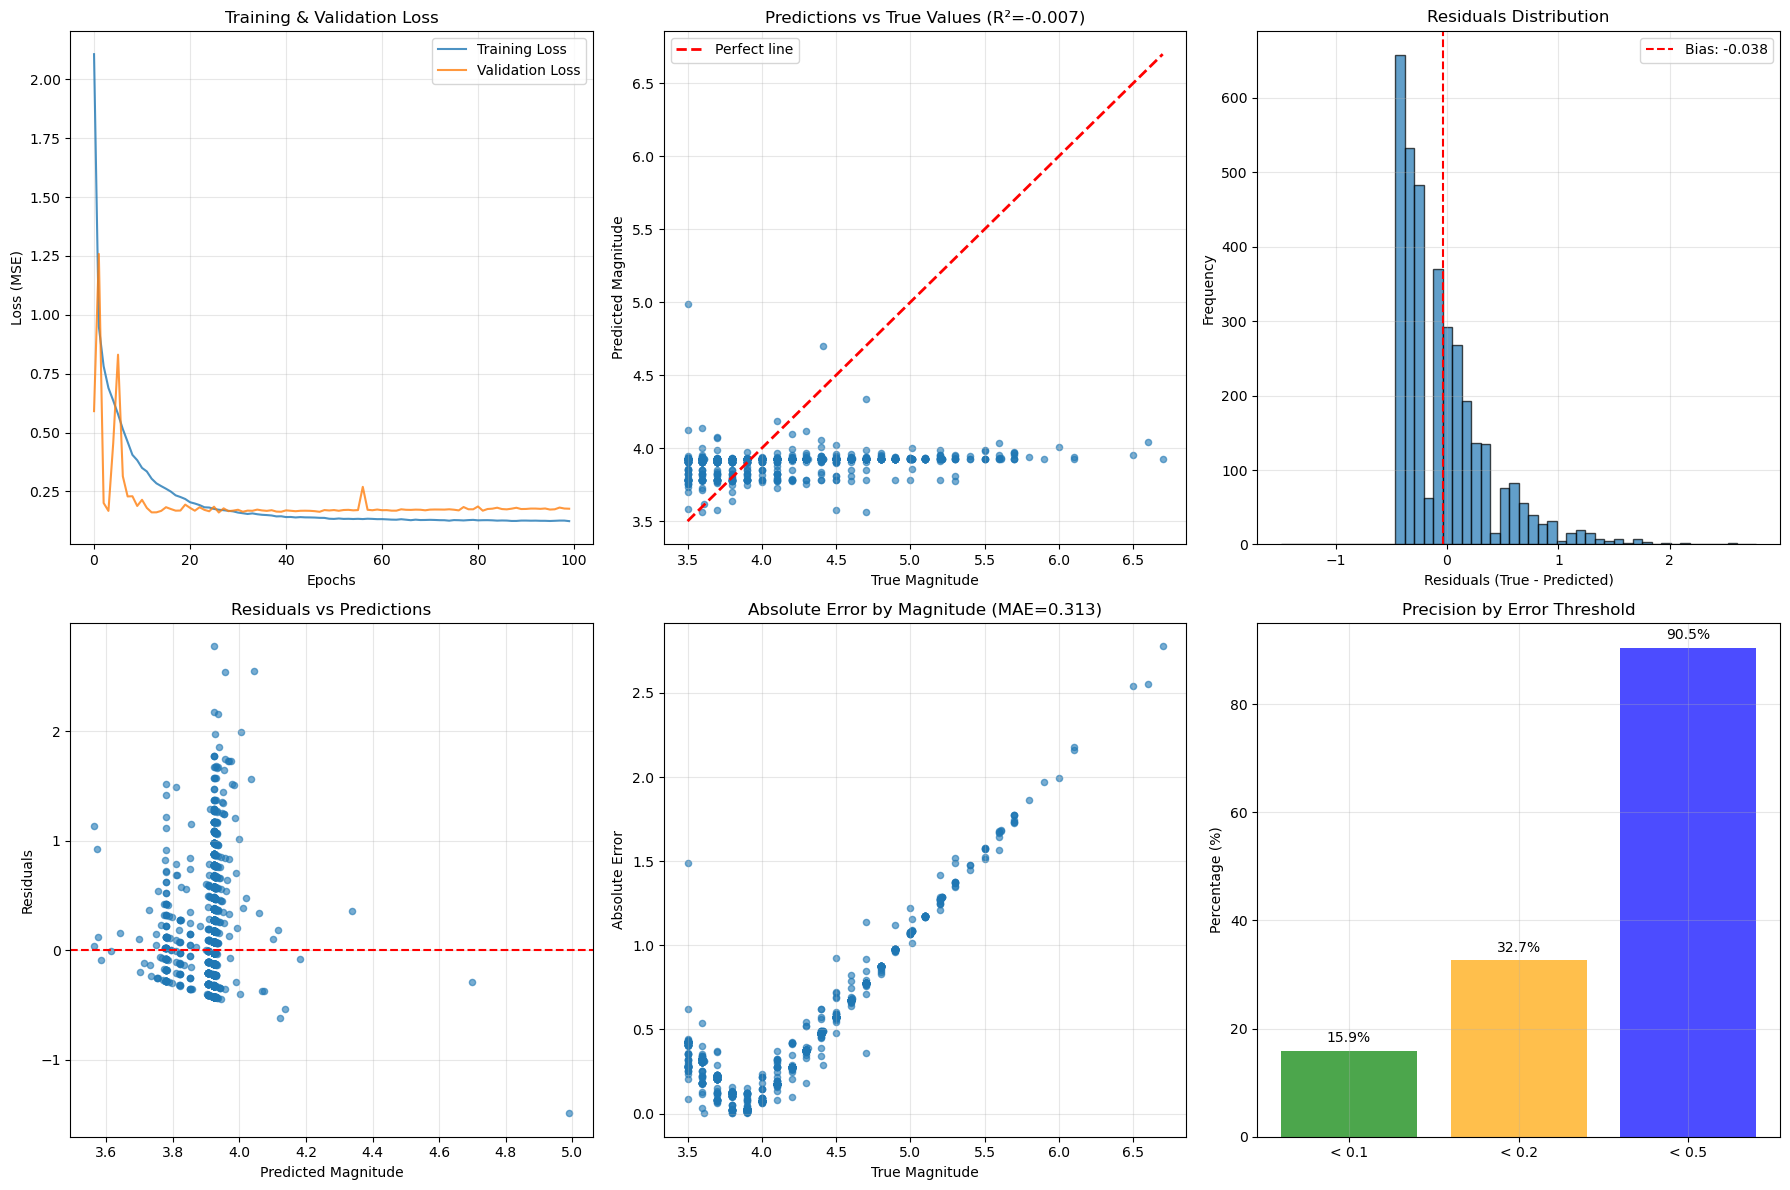


🏆 PERFORMANCE SUMMARY:
• Average error of ±0.31 magnitude
• 33% of predictions within ±0.2 magnitude
• -0.7% of variance explained
✅ No significant bias detected


In [12]:
# Paramètres
seconds = 5
sample_rate = 50
DATA_FILE = f"seismic_data_{seconds}_seconds_sampling_rate_{sample_rate}.pkl"
TARGET_LENGTH = seconds * sample_rate  # 5 secondes * 100 Hz = 500

run_experiment(seconds, sample_rate, DATA_FILE, TARGET_LENGTH, batch_size=32, num_epochs=100, learning_rate=0.001, is_augmented=False)

Run with 5 seconds, sample rate = 50 with augmentation

Loading data...
Data with sampling rate 50: 17773 samples
Train: 10663, Val: 3555, Test: 3555
🔄 277 rare samples will be augmented
Magnitude range: 3.50 - 7.50
Model created with 287809 parameters

=== START TRAINING ===
Device: cuda
Weighted Loss - Ranges: [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
Weighted Loss - Weights: [1.0, 2.0, 5.0, 10.0]
Using Weighted Loss to handle class imbalance
Epoch [0/100], Train Loss: 2.5774, Val Loss: 1.2964
Epoch [10/100], Train Loss: 0.5959, Val Loss: 0.1674
Epoch [20/100], Train Loss: 0.4014, Val Loss: 0.1613
Epoch [30/100], Train Loss: 0.3358, Val Loss: 0.1624
Epoch [40/100], Train Loss: 0.2976, Val Loss: 0.1690
Epoch [50/100], Train Loss: 0.2684, Val Loss: 0.1596
Epoch [60/100], Train Loss: 0.2644, Val Loss: 0.1623
Epoch [70/100], Train Loss: 0.2462, Val Loss: 0.1650
Epoch [80/100], Train Loss: 0.2463, Val Loss: 0.1654
Epoch [90/100], Train Loss: 0.2366, Val Loss: 0.1668

=== DETAILED EVALUATION RESULTS ===
📊 Global metrics:
   MAE: 0.3022 m

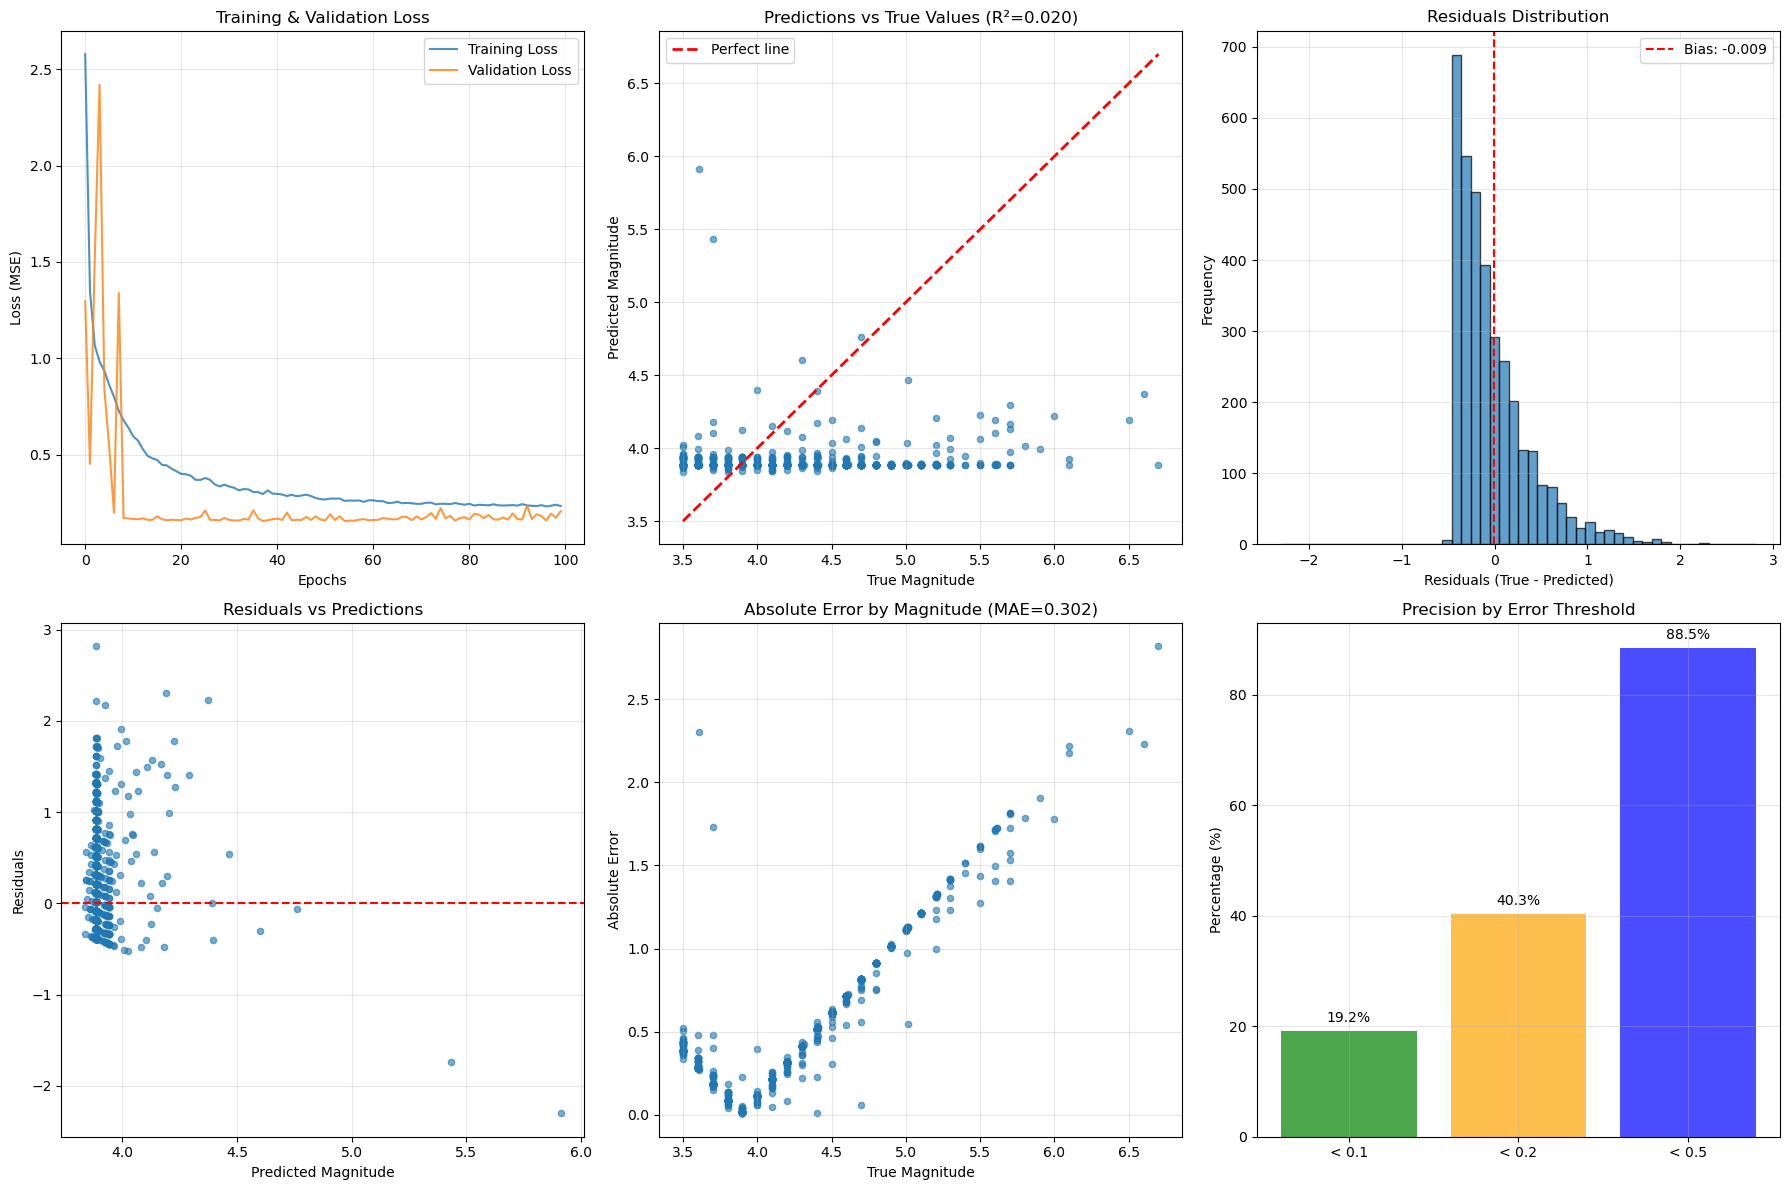


🏆 PERFORMANCE SUMMARY:
• Average error of ±0.30 magnitude
• 40% of predictions within ±0.2 magnitude
• 2.0% of variance explained
✅ No significant bias detected


In [13]:
# Paramètres
seconds = 5
sample_rate = 50
DATA_FILE = f"seismic_data_{seconds}_seconds_sampling_rate_{sample_rate}.pkl"
TARGET_LENGTH = seconds * sample_rate  # 5 secondes * 100 Hz = 500

run_experiment(seconds, sample_rate, DATA_FILE, TARGET_LENGTH, batch_size=32, num_epochs=100, learning_rate=0.001, is_augmented=True)

Run with 5 seconds, sample rate = 100 without augmentation

Loading data...
Data with sampling rate 100: 12671 samples
Train: 7602, Val: 2534, Test: 2535
Magnitude range: 3.50 - 7.50
Model created with 287809 parameters

=== START TRAINING ===
Device: cuda
Using standard MSE Loss
Epoch [0/100], Train Loss: 1.9074, Val Loss: 0.8123
Epoch [10/100], Train Loss: 0.4449, Val Loss: 0.1576
Epoch [20/100], Train Loss: 0.2719, Val Loss: 0.1374
Epoch [30/100], Train Loss: 0.1945, Val Loss: 0.1402
Epoch [40/100], Train Loss: 0.1688, Val Loss: 0.1357
Epoch [50/100], Train Loss: 0.1547, Val Loss: 0.1434
Epoch [60/100], Train Loss: 0.1444, Val Loss: 0.1330
Epoch [70/100], Train Loss: 0.1331, Val Loss: 0.1433
Epoch [80/100], Train Loss: 0.1290, Val Loss: 0.1343
Epoch [90/100], Train Loss: 0.1251, Val Loss: 0.1410

=== DETAILED EVALUATION RESULTS ===
📊 Global metrics:
   MAE: 0.3420 magnitude
   RMSE: 0.4417
   R²: -0.2307
   Mean bias: -0.1490
   Residual std: 0.4158

🎯 Precision by thresholds:
   Error < 0.1 mag: 15.0%
   Error < 0.2 mag: 31.9%
   Error < 0.

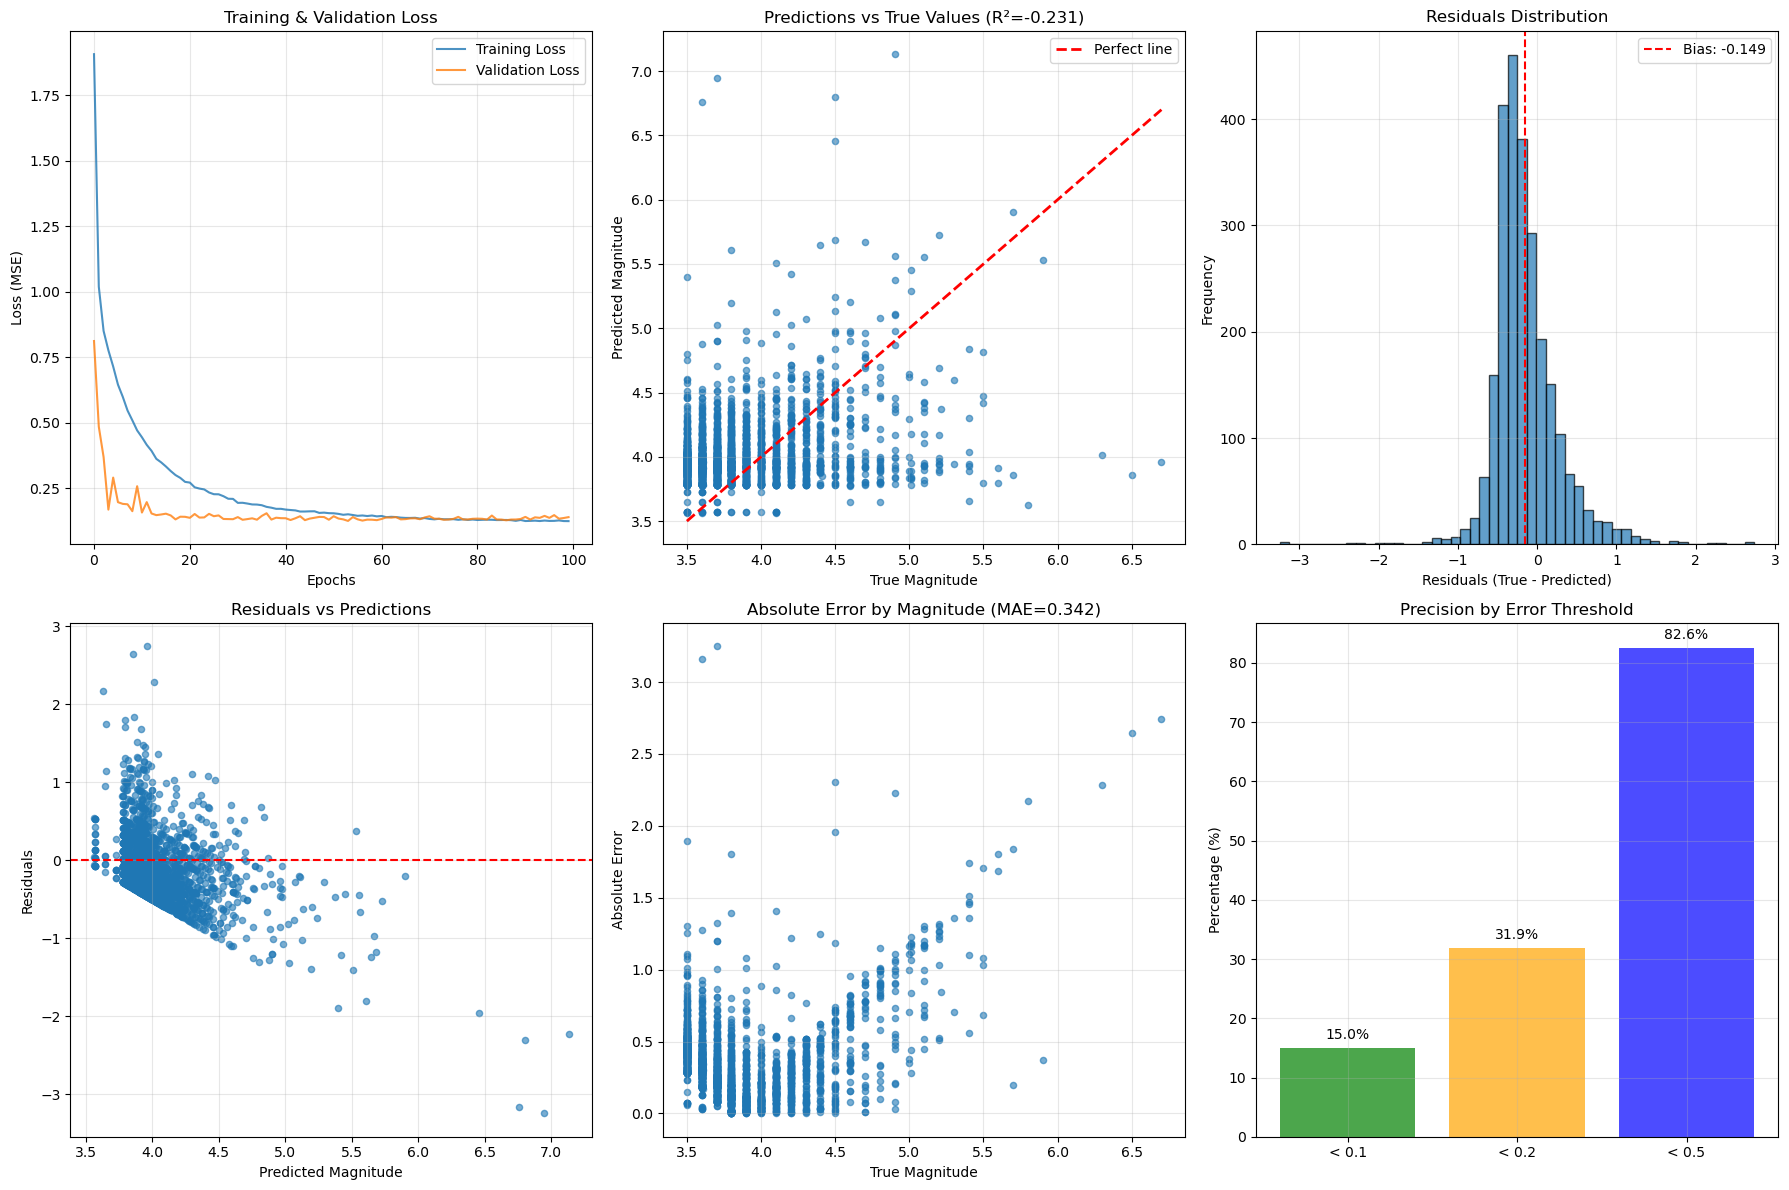


🏆 PERFORMANCE SUMMARY:
• Average error of ±0.34 magnitude
• 32% of predictions within ±0.2 magnitude
• -23.1% of variance explained
⚠️  Bias detected: systematic underestimation of 0.149


In [14]:

# Paramètres
seconds = 5
sample_rate = 100
DATA_FILE = f"seismic_data_{seconds}_seconds_sampling_rate_{sample_rate}.pkl"
TARGET_LENGTH = seconds * sample_rate  # 5 secondes * 100 Hz = 500

run_experiment(seconds, sample_rate, DATA_FILE, TARGET_LENGTH, batch_size=32, num_epochs=100, learning_rate=0.001, is_augmented=False)

Run with 5 seconds, sample rate = 100 with augmentation

Loading data...
Data with sampling rate 100: 12671 samples
Train: 7602, Val: 2534, Test: 2535
🔄 208 rare samples will be augmented
Magnitude range: 3.50 - 7.50
Model created with 287809 parameters

=== START TRAINING ===
Device: cuda
Weighted Loss - Ranges: [(3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
Weighted Loss - Weights: [1.0, 2.0, 5.0, 10.0]
Using Weighted Loss to handle class imbalance
Epoch [0/100], Train Loss: 2.4020, Val Loss: 0.1851
Epoch [10/100], Train Loss: 0.6912, Val Loss: 0.1521
Epoch [20/100], Train Loss: 0.4488, Val Loss: 0.1455
Epoch [30/100], Train Loss: 0.3838, Val Loss: 0.1372
Epoch [40/100], Train Loss: 0.3470, Val Loss: 0.1333
Epoch [50/100], Train Loss: 0.3272, Val Loss: 0.1313
Epoch [60/100], Train Loss: 0.3107, Val Loss: 0.1317
Epoch [70/100], Train Loss: 0.2975, Val Loss: 0.1303
Epoch [80/100], Train Loss: 0.2951, Val Loss: 0.1431
Epoch [90/100], Train Loss: 0.2835, Val Loss: 0.1368

=== DETAILED EVALUATION RESULTS ===
📊 Global metrics:
   MAE: 0.2705 m

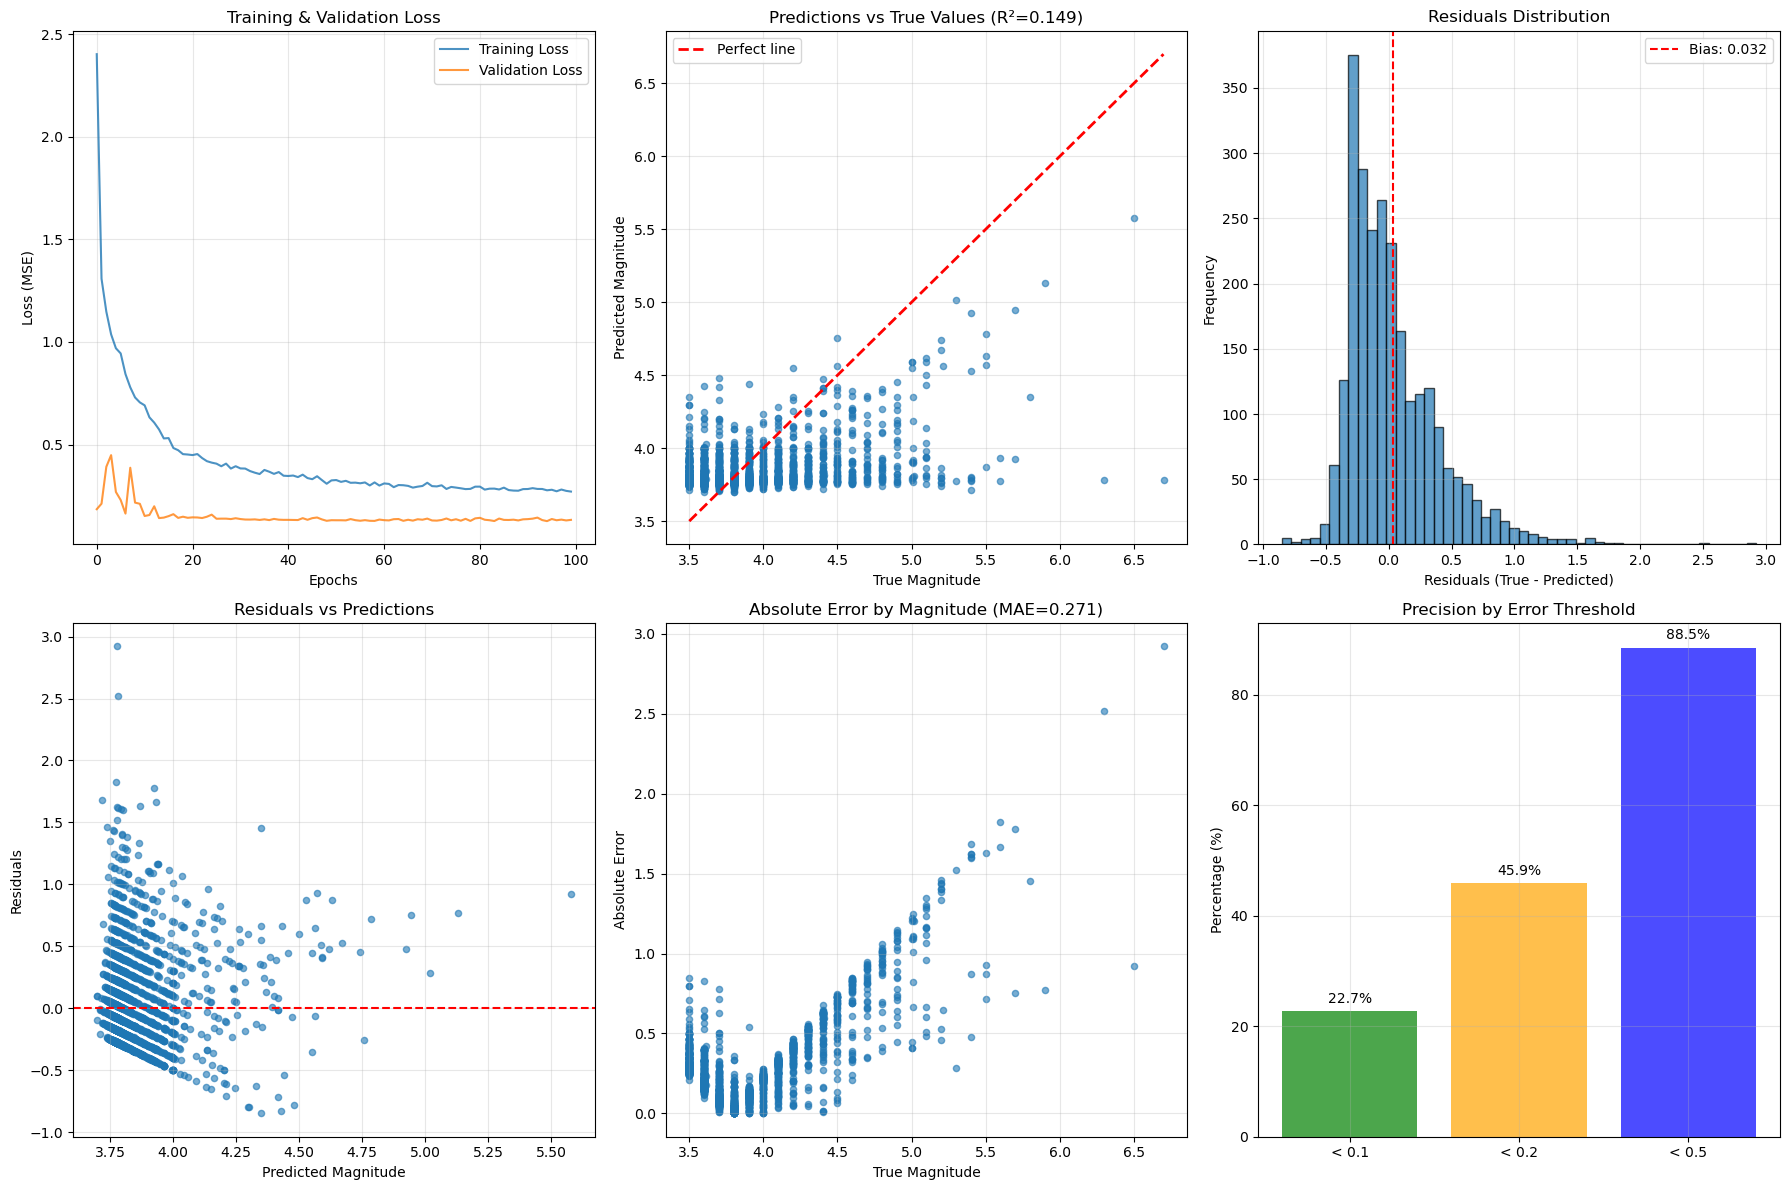


🏆 PERFORMANCE SUMMARY:
• Average error of ±0.27 magnitude
• 46% of predictions within ±0.2 magnitude
• 14.9% of variance explained
✅ No significant bias detected


In [18]:


# Paramètres
seconds = 5
sample_rate = 100
DATA_FILE = f"seismic_data_{seconds}_seconds_sampling_rate_{sample_rate}.pkl"
TARGET_LENGTH = seconds * sample_rate  # 5 secondes * 100 Hz = 500

run_experiment(seconds, sample_rate, DATA_FILE, TARGET_LENGTH, batch_size=32, num_epochs=100, learning_rate=0.001, is_augmented=True)


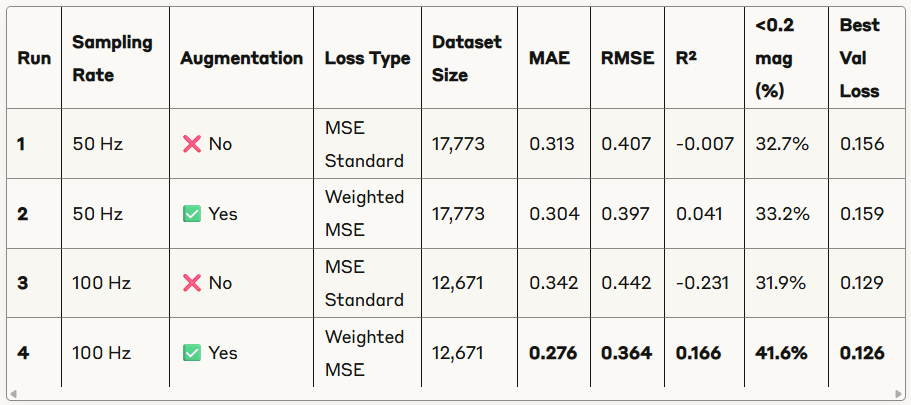

📈 KEY FINDINGS:
🎯 Best Performance: Run 4 (100Hz + Augmentation)

16.6% variance explained (R² = 0.166)

±0.276 magnitude average error

41.6% predictions within ±0.2 magnitude


Critical Insights:

100Hz alone performs WORSE than 50Hz (overfitting)
Data augmentation is CRUCIAL for 100Hz (regularization effect)
50Hz is more robust but has lower ceiling performance
Weighted loss + augmentation provides best results

Performance by Magnitude Range (Run 4):

Mag 3.5-4.5: 2,307 samples, MAE = 0.224

Mag 4.5-5.5: 215 samples, MAE = 0.766

Mag 5.5-6.5: 11 samples, MAE = 1.358

Mag 6.5-7.5: 2 samples, MAE = 1.914


⚠Remaining Challenge:
High magnitude events (>5.5) still show poor performance due to extreme class imbalance.

RECOMMENDED CONFIGURATION: 100Hz + Augmentation + Weighted Loss

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from obspy import read
import os

def plot_problematic_cases(samples, case_list, data_folder= "Turkey_data/DATA", problem_types=None):
    """
    Display specific problematic seismic samples for research presentations.

    Args:
        samples (list or DataFrame): Dataset samples (list of dicts or pandas DataFrame)
        case_list (list): List of (event_id, station) tuples
        data_folder (str): Path to .mseed files
        problem_types (list): Problem descriptions for each case
    """
    # Convert DataFrame to list of dicts if needed
    if hasattr(samples, 'to_dict'):  # It's a DataFrame
        samples = samples.to_dict('records')

    n_cases = len(case_list)
    fig, axes = plt.subplots(n_cases, 2, figsize=(16, 4 * n_cases))  # 2 columns: original + snippet
    if n_cases == 1:
        axes = axes.reshape(1, -1)  # Ensure 2D array even for single case

    # Colors for components
    colors = {"Z": "black", "N": "green", "E": "purple"}
    snippet_colors = {"Z": "blue", "N": "orange", "E": "red"}

    for idx, (event_id, station_name) in enumerate(case_list):
        ax_original = axes[idx, 0]  # Left subplot: original trace
        ax_snippet = axes[idx, 1]   # Right subplot: snippet

        # Find sample in dataset
        sample = None
        for s in samples:
            if s["event_id"] == event_id and s["station"] == station_name:
                sample = s
                break

        if sample is None:
            for ax in [ax_original, ax_snippet]:
                ax.text(0.5, 0.5, f"Sample not found:\nEvent {event_id}\nStation {station_name}",
                       ha='center', va='center', transform=ax.transAxes, color='red')
            continue

        snippet = sample["snippet"]
        magnitude = sample["event_magnitude"]
        distance_km = sample["distance_m"] / 1000

        # Load original traces
        try:
            original_path = os.path.join(data_folder, f"{event_id}.mseed")
            stream = read(original_path)
            station_traces = [tr for tr in stream if tr.stats.station == station_name]
            components = {tr.stats.channel[-1]: tr for tr in station_traces
                         if tr.stats.channel[-1] in ("Z", "N", "E")}
        except:
            for ax in [ax_original, ax_snippet]:
                ax.text(0.5, 0.5, f"Cannot load {event_id}.mseed",
                       ha='center', va='center', transform=ax.transAxes, color='red')
            continue

        # Plot ORIGINAL traces (left subplot)
        for comp in ["Z", "N", "E"]:
            if comp in components:
                tr = components[comp]
                times_full = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)
                ax_original.plot(times_full, tr.data, color=colors[comp], label=f"Original {comp}")

        ax_original.set_title(f"Original Trace - Event {event_id}, Station {station_name}")
        ax_original.set_xlabel("Time (s)")
        ax_original.set_ylabel("Amplitude")
        ax_original.legend()
        ax_original.grid(True, alpha=0.3)

        # Plot SNIPPET (right subplot)
        snippet_duration = snippet.shape[1] / sample["sampling_rate"]
        times_snippet = np.linspace(0, snippet_duration, snippet.shape[1])

        for i, comp in enumerate(["Z", "N", "E"]):
            ax_snippet.plot(times_snippet, snippet[i], color=snippet_colors[comp],
                           linewidth=2, label=f"Snippet {comp}")

        problem_desc = problem_types[idx] if problem_types and idx < len(problem_types) else "Issue"
        ax_snippet.set_title(f"{problem_desc} - Snippet (Mag {magnitude:.1f})")
        ax_snippet.set_xlabel("Time (s)")
        ax_snippet.set_ylabel("Amplitude")
        ax_snippet.legend()
        ax_snippet.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

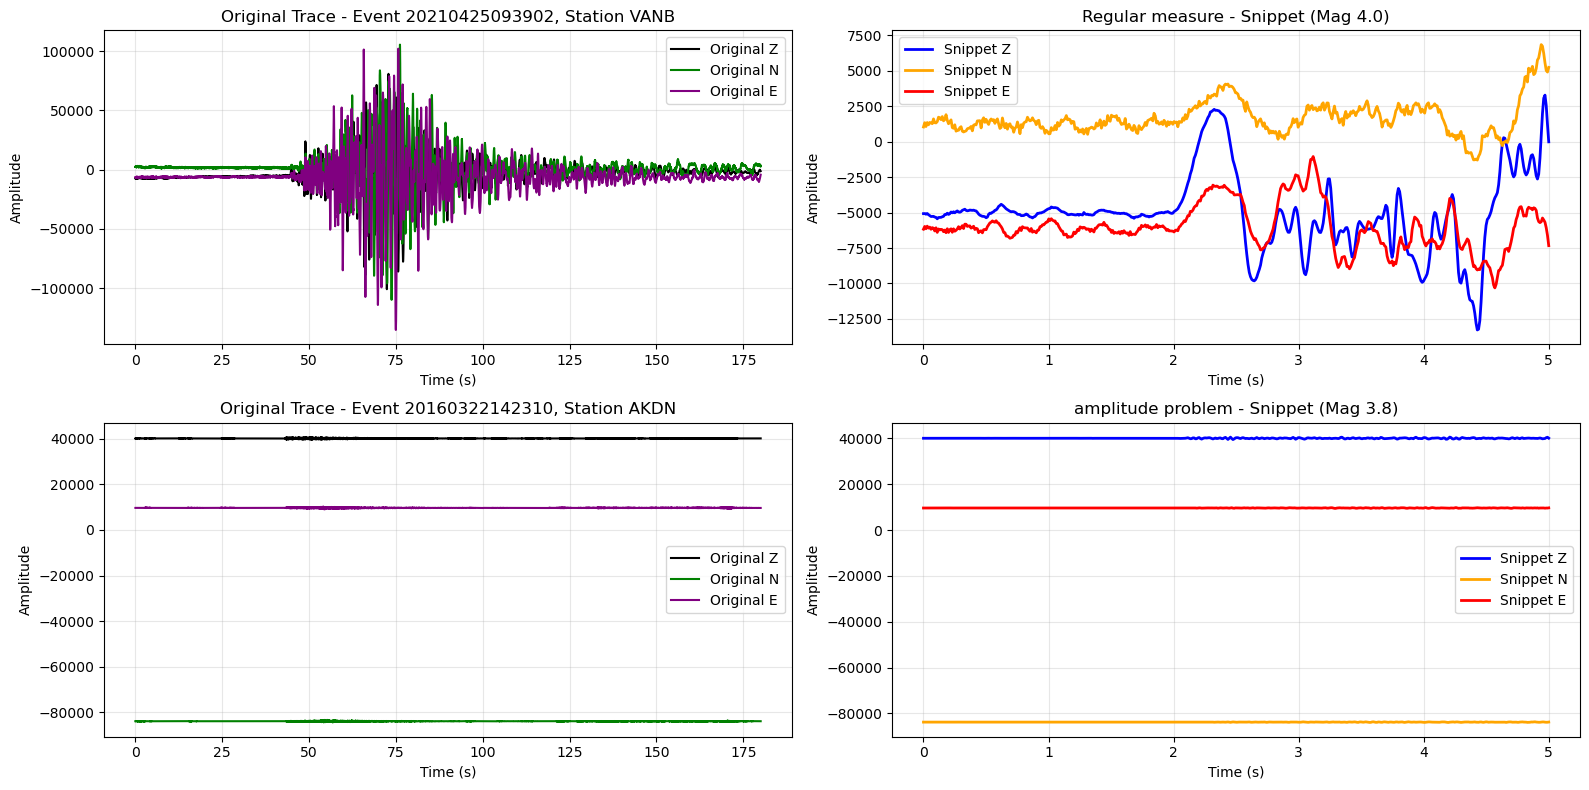

In [17]:
# Displaying sample: Event 20210425093902 at Station VANB

# Displaying sample: Event 20160322142310 at Station AKDN


# Tes cas problématiques
cases = [
    ("20210425093902", "VANB"),
    ("20160322142310", "AKDN")
]

problems = [
    "Regular measure",
    "amplitude problem"
]
DATA_FILE = f"seismic_data_5_seconds_sampling_rate_100.pkl"
with open(DATA_FILE, 'rb') as f:
        dataset = pickle.load(f)
plot_problematic_cases(dataset, cases, data_folder="Turkey_data/DATA", problem_types=problems)